# 1.Fuction import

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import cmocean.cm as cm
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.gridliner as gridliner
import datetime
import calendar 
import sys
import os
import glob
import gsw
import json
import time
# Add the current directory to the system path
sys.path.append('/g/data/jk72/zc0441')
# from clef.code import *
from dask.distributed import Client, LocalCluster
from dask_jobqueue import SLURMCluster
from zpackage import wmt
from zpackage.zclef import Zlook,Zsearch

In [2]:
# cluster = LocalCluster()
# client = Client(cluster)
# client


In [3]:
# model = 'ACCESS-CM2' 		 ## 'ACCESS-CM2' 'ACCESS-ESM1-5' 'CAS-ESM2-0' 'CanESM5' 'FIO-ESM-2-0' 'CNRM-CM6-1' 'FGOALS-g3' 'IPSL-CM6A-LR' 'CMCC-CM2-HR4' 'EC-Earth3'
variable_list = ['tos', 'sos', 'hfds', 'wfo' ,'vmo', 'so' ,'thetao']
# variable_list_si = [ 'siconc','sidmassdyn','sidmassth'] # 'sispeed'
variable_list_si = [ 'siconc','sidmassth'] # 'sispeed'
variable_list_si_dyn = [ 'siconc','sidmassdyn']

frequency = ['mon']
experiment = ['historical']
member_id = ['r1i1p1f1', 'r1i1p1f2']
realm = ['ocean']
grid_label = ['gn']

yrst = '1979'; yren = '2014'
lat_edge = -45

figure_plot_trigger = False
data_save_trigger = True # False #
file_path = '/g/data/jk72/zc0441/Subject_1/model_list.json'
fig_path = '/g/data/jk72/zc0441/Figures/20230626/'


In [4]:
constraint = {'variable_id': variable_list,'frequency': frequency, 'realm': realm ,'member_id': member_id, 'experiment_id': experiment,'grid_label':grid_label}
constraint_si = {'variable_id': variable_list_si,'frequency': frequency, 'member_id': member_id, 'experiment_id': experiment,'grid_label':grid_label}
constraint_si_dyn = {'variable_id': variable_list_si_dyn,'frequency': frequency, 'member_id': member_id, 'experiment_id': experiment,'grid_label':grid_label}
df = Zsearch(constraint)
df_si = Zsearch(constraint_si)
df_si_dyn = Zsearch(constraint_si_dyn)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/clef/code.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(search(session,project=project.upper(),
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/clef/code.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(search(session,project=project.upper(),
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/clef/code.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(search(session,project=project.upper(),
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/clef/code.py:

In [5]:
model_list = ['ACCESS-CM2',
             'ACCESS-ESM1-5',
             'CNRM-CM6-1',
             'CNRM-CM6-1-HR',
             'CNRM-ESM2-1',
             'EC-Earth3',
             'EC-Earth3-AerChem',
             'EC-Earth3-CC',
             'FGOALS-f3-L',
             'FGOALS-g3',
             'IPSL-CM6A-LR',
             'IPSL-CM6A-LR-INCA',
             'MIROC6',
             'NorESM2-LM',
             'NorESM2-MM',
             'UKESM1-0-LL']

model_list_si = ['ACCESS-CM2',
             'CNRM-CM6-1',
             'CNRM-CM6-1-HR',
             'CNRM-ESM2-1',
             'FGOALS-f3-L',
             'FGOALS-g3',
             'IPSL-CM6A-LR',
             'IPSL-CM6A-LR-INCA',
             'NorESM2-LM',
             'NorESM2-MM',
             'UKESM1-0-LL']
model_list_si_dyn = ['CNRM-CM6-1',
                    'CNRM-CM6-1-HR',
                    'CNRM-ESM2-1',
                    'UKESM1-0-LL']

len(model_list_si)

11

In [6]:
model_list_si[1:2]

['CNRM-CM6-1']

In [7]:
# sith.sel(time = yrst + '-07').plot() #where(sith[lat_key]>50).mean().values

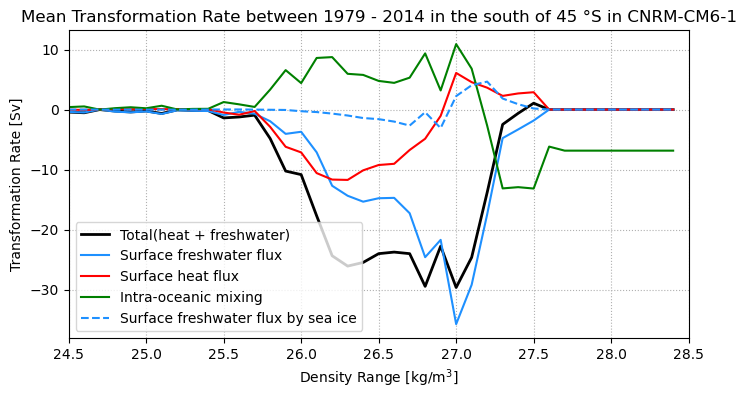

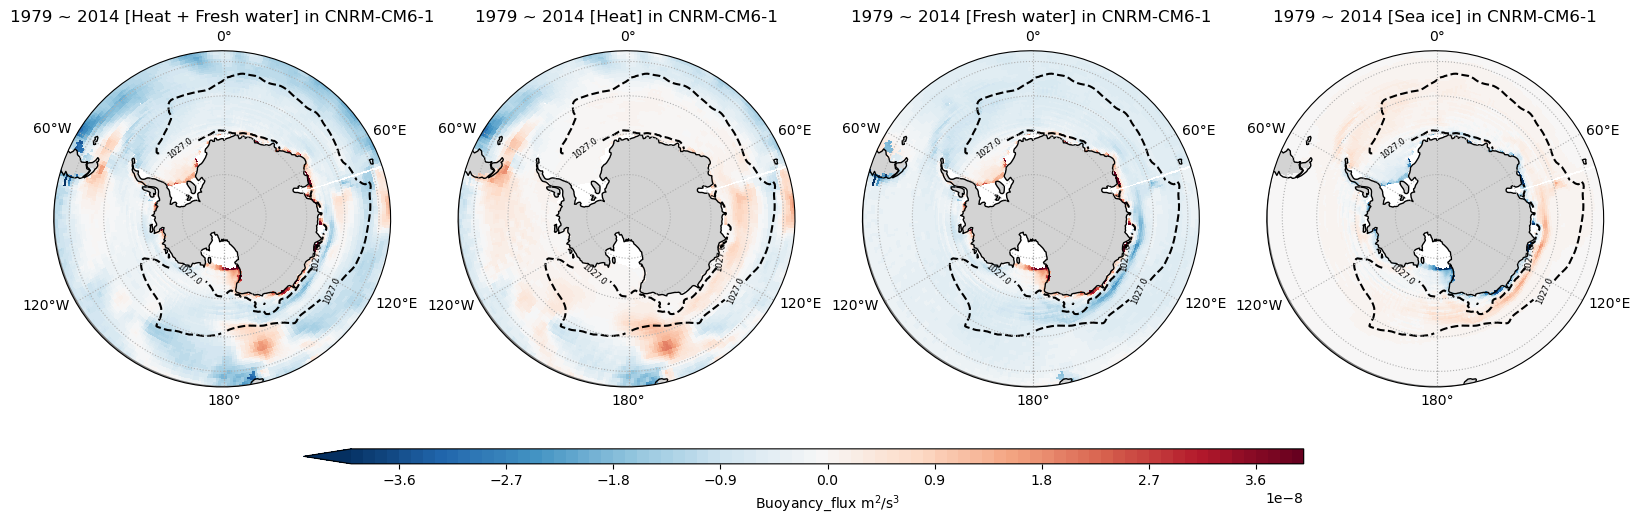

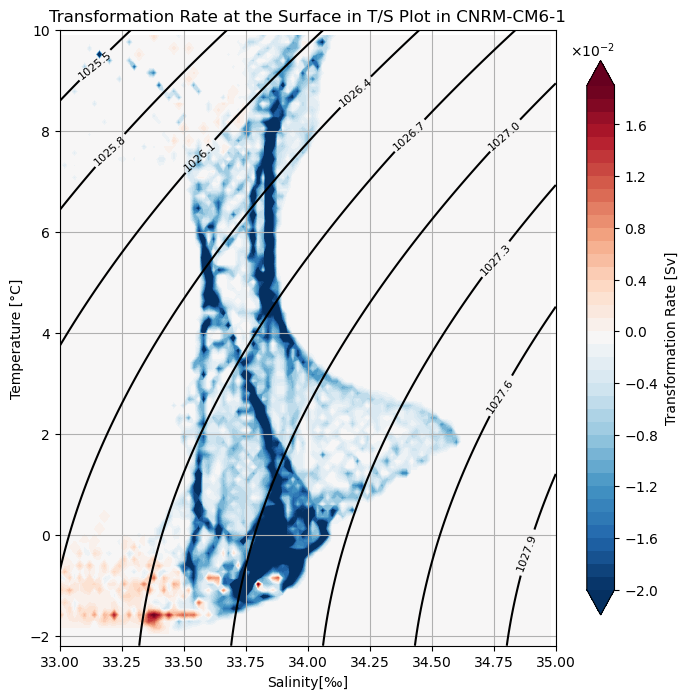

PermissionError: [Errno 13] Permission denied: b'/g/data/jk72/zc0441/Subject_1/Data/Transf_CNRM-CM6-1_1979_2014.nc'

In [18]:
for model in model_list_si[1:2]:
    file_paths= df.variable_paths(model) # allocate the file paths

    # select avaliable data for the model
    if model in model_list_si_dyn:
        file_paths_si = df_si_dyn.variable_paths(model)
        variable_list_si = [ 'siconc','sidmassdyn']
    else:
        file_paths_si = df_si.variable_paths(model)
        variable_list_si = [ 'siconc','sidmassth']

    # add a flag for model UKESM1-0-LL, cause the cell area data saved in different experiment
    if 'UKESM1' in model:  
        df_ga = Zlook({'variable': 'areacello', 'model': model}) # The sea grid area 
    else:
        df_ga = Zlook({'variable': 'areacello', 'model': model, 'experiment': 'historical' ,'grid_label': 'gn'}) # The sea grid area 

    grid_area = xr.open_dataset(df_ga.kw_search(df_ga.path(),'1')[0])[df_ga.v()] # allocate the data 


    ## Find the coord key for model
    dim_list = list(grid_area.dims)+ list(grid_area.coords.keys())
    lat_key = None
    lon_key = None
    lat_keys = ['latitude', 'lat', 'nav_lat']
    lon_keys = ['longitude', 'lon', 'nav_lon']
    j_keys = ['y','j']
    i_keys = ['x','i']
    for key in dim_list:

        if key in lat_keys:
            lat_key = key
        if key in lon_keys:
            lon_key = key
        if key in j_keys:
            j_key = key
        if key in i_keys:
            i_key = key

    tem = xr.open_mfdataset(file_paths[0]+'/*.nc', combine='by_coords', parallel=True)[variable_list[0]].sel(time = slice(yrst, yren))
    sal = xr.open_mfdataset(file_paths[1]+'/*.nc', combine='by_coords', parallel=True)[variable_list[1]].sel(time = slice(yrst, yren))
    hf = xr.open_mfdataset(file_paths[2]+'/*.nc', combine='by_coords', parallel=True)[variable_list[2]].sel(time = slice(yrst, yren))           
    fwf = xr.open_mfdataset(file_paths[3]+'/*.nc', combine='by_coords', parallel=True)[variable_list[3]].sel(time = slice(yrst, yren))
    mty = xr.open_mfdataset(file_paths[4]+'/*.nc', combine='by_coords', parallel=True)[variable_list[4]].sel(time = slice(yrst, yren))

    sic = xr.open_mfdataset(file_paths_si[0]+'/*.nc', combine='by_coords', parallel=True)[variable_list_si[0]].sel(time = slice(yrst, yren))
    # simd = xr.open_mfdataset(file_paths_si[1]+'/*.nc', combine='by_coords', parallel=True)[variable_list_si[1]].sel(time = slice(yrst, yren))
    sith = xr.open_mfdataset(file_paths_si[1]+'/*.nc', combine='by_coords', parallel=True)[variable_list_si[1]].sel(time = slice(yrst, yren))

    pre =xr.zeros_like(hf)

    # Search the grid along the selected latitude boundary
    latitude = mty[lat_key].values
    nearest_index = np.abs(latitude - lat_edge).argmin(axis=0)
    if isinstance(nearest_index, np.ndarray): # In case the nearest_index is a list
        nearest_index = nearest_index[0]

    # Select the salinity and temperature along the selected latitude
    sal_ver = xr.open_mfdataset(file_paths[5]+'/*.nc', combine='by_coords', parallel=True)[variable_list[5]][:,:,nearest_index,:].sel(time = slice(yrst, yren)).mean('time').compute()
    tem_ver = xr.open_mfdataset(file_paths[6]+'/*.nc', combine='by_coords', parallel=True)[variable_list[6]][:,:,nearest_index,:].sel(time = slice(yrst, yren)).mean('time').compute()  #.sel(**{j_key : nearest_index, 'time' : slice(yrst, yren)}).
    pre_ver = xr.zeros_like(tem_ver)

    # calculate the total transportation within the boundary
    mt = mty[:,:,nearest_index,:].mean('time').compute()
    den_ver = gsw.rho(sal_ver,tem_ver,pre_ver)
    tr = mt/den_ver

    # The heat flux and freshwater flux direction check
    hf_dir_check_sample = hf.sel(time = yrst + '-07').where(hf[lat_key]>30).mean()
    fwf_dir_check_sample = fwf.sel(time = yrst + '-07').where(fwf[lat_key]>50).mean()
    sith_dir_check_sample = sith.sel(time = yrst + '-07').where(sith[lat_key]<-70).mean()

    if hf_dir_check_sample < 0:
        hf = -hf
    if fwf_dir_check_sample < 0:
        fwf = -fwf
    if sith_dir_check_sample <0:
        sith = -sith


    # Variable mean
    hf_mean = hf.where(grid_area[lat_key]<lat_edge).mean('time').compute()
    fwf_mean = fwf.where(grid_area[lat_key]<lat_edge).mean('time').compute()
    sal_mean = sal.where(grid_area[lat_key]<lat_edge).mean('time').compute()
    tem_mean = tem.where(grid_area[lat_key]<lat_edge).mean('time').compute()
    sic_mean = sic.where(sic[lat_key]<lat_edge).mean('time').compute()
    # simd_mean = simd.where(simd[lat_key]<lat_edge).mean('time').compute()
    sith_mean = sith.where(sith[lat_key]<lat_edge).mean('time').compute()
    
    sic_sep_mean = sic.sel(time=sic['time.month'] == 9).mean(dim='time')
    sic_sep_mean = sic_sep_mean.where(sic_sep_mean[lat_key]<lat_edge) ## The max sea ice extent
    
    ##====Only for the FGOALS models, where the sea ice grid is reversied ====##
    if 'FGOALS' in model:
        sith_mean_m = sith_mean.loc[dict(j=slice(None, None, -1))]
        sith_mean = xr.DataArray(sith_mean_m, coords=fwf_mean.coords, dims=fwf_mean.dims)
    
    pre_mean = xr.zeros_like(hf_mean)
    density_mean = gsw.rho(sal_mean, tem_mean, pre_mean)

    tr_heat_weighted = wmt.trans_rate_heat(hf_mean, sal_mean, tem_mean, pre_mean) * grid_area
    tr_fwf_weighted = wmt.trans_rate_water(fwf_mean, sal_mean, tem_mean, pre_mean) * grid_area
    tr_sith_weighted = wmt.trans_rate_water(sith_mean, sal_mean, tem_mean, pre_mean) * grid_area
    sic_weighted = sic_mean * grid_area

    ### Flag session only for FGOALS models
    if 'FGOALS' in model:
        result_values = mt.values / den_ver.values
        # Create a new DataArray from the result_values array
        tr = xr.DataArray(result_values, coords=den_ver.coords, dims=den_ver.dims)

    my_array = mt[lon_key].values
    unique_values, unique_indices = np.unique(my_array, return_index=True)
    # Check if the array contains duplicates
    has_duplicates = len(unique_values) < len(my_array)
    
    if 'EC-Earth' or 'CNRM-CM6-1-HR' in model:
        if has_duplicates:
            # Select the unique values 
            tr_heat_weighted = tr_heat_weighted[:,unique_indices]
            tr_fwf_weighted = tr_fwf_weighted[:,unique_indices]
            tr_sith_weighted = tr_sith_weighted[:,unique_indices]
            tr = tr[:,unique_indices]
            sic_mean = sic_mean[:,unique_indices]
            sic_sep_mean = sic_sep_mean[:,unique_indices]
            density_mean = density_mean[:,unique_indices]
            den_ver = den_ver[:,unique_indices]
            sal_ver = sal_ver[:,unique_indices]
            tem_ver = tem_ver[:,unique_indices]
            sal_mean = sal_mean[:,unique_indices]
            tem_mean = tem_mean[:,unique_indices]
            sith_mean = sith_mean[:,unique_indices]
            sic_weighted =sic_weighted[:,unique_indices]
            hf_mean = hf_mean[:,unique_indices]
            fwf_mean = fwf_mean[:,unique_indices]

    den_sorted = density_mean.sortby(density_mean[lon_key][nearest_index,:])

    # Data sortation by density range 
    tr_list_all = [] ; tr_list_hf = [] ; tr_list_fwf= [] ; tr_list_tran = [] ; 
    tr_list_mix = [] ; tr_list_sic = []; tr_list_sid=[]; tr_list_fwf_si=[]; tr_list_hf_si=[]
    tr_list_sith = []
    x_lim = [24.5,28.5]
    interval = 0.1  # Set the interval for the water mass transformation
    sverdrop = 10**6 # Unit for severdrop 10^6 m^3/s
    km2 = 10**6 # Unit for km2
    sea_ice_threshold = 1.25  # The sea ice concentration threshold for freshwater flux integration

    density_range =  np.arange(x_lim[0], x_lim[1], interval) 
    density_applied = density_mean.where(density_mean[lat_key]<lat_edge) # sift the density range

    for den in density_range:
        den_left = 1000 + den - interval/2; den_right = 1000 + den + interval/2 # the right and left density boundary 

        #====Here the density difference is setted as half interval 
        den_dif = interval
        tr_hf = tr_heat_weighted.where(density_applied > den_left).where(density_applied < den_right) / den_dif  / sverdrop
        tr_hf_si = tr_heat_weighted.where(density_applied > den_left).where(density_applied < den_right).where(sic_mean>sea_ice_threshold) / den_dif  / sverdrop
        tr_fwf = tr_fwf_weighted.where(density_applied > den_left).where(density_applied < den_right)  / den_dif / sverdrop
        tr_fwf_si = tr_fwf_weighted.where(density_applied > den_left).where(density_applied < den_right).where(sic_mean>sea_ice_threshold)  / den_dif / sverdrop
        tr_tran = tr.where(den_ver<den_right) / sverdrop
        # tr_sic = sic_weighted.where(density_applied > den_left).where(density_applied < den_right) ## sic area integration
        tr_sic = sic_weighted.where(density_applied < den_right) / km2 ## sic area integration
        tr_si_distribute = sic_weighted.where(density_applied > den_left).where(density_applied < den_right) # sea ice distribution
        tr_sith = tr_sith_weighted.where(density_applied > den_left).where(density_applied < den_right)  / den_dif / sverdrop
        # Ocean realm
        hf_all = tr_hf.sum().values.item()
        fwf_all = tr_fwf.sum().values.item()
        tran_all = -tr_tran.sum().values.item()
        hf_si_all = tr_hf_si.sum().values.item()
        fwf_si_all = tr_fwf_si.sum().values.item()
        # sea ice realm
        sic_range_mean = tr_sic.sum().values.item()
        sic_distribution_mean = tr_si_distribute.sum().values.item()
        sith_all = tr_sith.sum().values.item()

        tr_list_all.append(hf_all+fwf_all)
        tr_list_hf.append(hf_all)
        tr_list_fwf.append(fwf_all)
        tr_list_tran.append(tran_all)
        tr_list_mix.append(tran_all - hf_all - fwf_all)
        tr_list_sic.append(sic_range_mean)
        tr_list_sid.append(sic_distribution_mean)
        tr_list_hf_si.append(hf_si_all)
        tr_list_fwf_si.append(fwf_si_all)
        tr_list_sith.append(sith_all)

    # Plot of the tansformation rate 
    fig_title = f'Mean Transformation Rate between {yrst} - {yren} in the south of {str(abs(lat_edge))} °S in {model}'

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

    ax = axs
    ax.plot(density_range, tr_list_all, label='Total(heat + freshwater)',linewidth=2, color = 'black')
    ax.plot(density_range, tr_list_fwf, label='Surface freshwater flux',color = 'dodgerblue')
    ax.plot(density_range, tr_list_hf, label='Surface heat flux',color = 'r')
    # ax.plot(density_range, tr_list_tran, label='M$_{45°S}$(Water volume transportation)',color = 'y')
    ax.plot(density_range, tr_list_mix, label='Intra-oceanic mixing',color = 'g')
    # ax.plot(density_range, tr_list_fwf_si, label='Surface fwf where covered by sea ice',linestyle = '--',color = 'b')
    ax.plot(density_range, tr_list_sith, label='Surface freshwater flux by sea ice',linestyle = '--',color = 'dodgerblue')
    # ax.plot(density_range,pd.array(tr_list_fwf) - pd.array(tr_list_sith), label='Surface freshwater flux exclude sea ice',linestyle = '--',color = 'y')


    # ax2 = ax.twinx()
    # ax2.plot(density_range, tr_list_sic, label='Sea ice area', color='gray', linestyle = '--')
    # ax2.set_ylabel('Accumulated Sea ice Area[km$^{2}$]')# ax.plot(density_range, tr_list_sic, label='sic')



    # Add a legend
    ax.legend()
    # ax2.legend(loc='lower right')

    # Add a grid
    ax.grid(linestyle = ':')

    # Set the x and y axis labels
    ax.set_xlabel('Density Range [kg/m$^3$]')
    ax.set_ylabel('Transformation Rate [Sv]')
    ax.set_title(fig_title)
    ax.set_xlim(x_lim)
    # ax.set_ylim(-40,40)
    if figure_plot_trigger:
        fig.savefig(fig_path + model +'.png')
    # fig.savefig(fig_path + model +'_1.png')

    pre_mean = 0   
    ######## 3.5 Transformation rate plot ######
    buo, buo_hf, buo_fwf = wmt.buoyancy_flux(hf_mean, fwf_mean, sal_mean, tem_mean, pre_mean, formula='default') 
    buo_si = wmt.buoyancy_flux_water(sith_mean,sal_mean, tem_mean, pre_mean)

    lat_edge = -45

    ###==== Removal of redundant values ===##
    
    if 'NorESM2' in model:
        # Select the unique values 
        buo = buo[:-1,:]
        buo_hf = buo_hf[:-1,:]
        buo_fwf  = buo_fwf[:-1,:]
        density_mean = density_mean[:-1,:]
        grid_area = grid_area[:-1,:]
    ###=====================================##
    
    buo_year = buo.where(buo[lat_key]<lat_edge)
    buo_hf_year = buo_hf.where(buo[lat_key]<lat_edge)
    buo_fwf_year = buo_fwf.where(buo[lat_key]<lat_edge)
    buo_si_year = buo_si.where(buo[lat_key]<lat_edge)


    sign_changes = np.where(np.diff(np.sign(tr_list_all)))[0]
    flip_point_den_pre = density_range[sign_changes[-1]]
    intercept = interval* (abs(tr_list_all[sign_changes[-1]+1])/(abs(tr_list_all[sign_changes[-1]]) + abs(tr_list_all[sign_changes[-1]+1])))
    # [abs(tr_list_all[sign_changes[-1]+1]), (abs(tr_list_all[sign_changes[-1]]) + abs(tr_list_all[sign_changes[-1]+1]))]

    flip_point_den = [flip_point_den_pre + intercept + 1000]
    flip_point_den

    value_list = tr_list_sith

    sign_changes = np.where(np.diff(np.sign(value_list)))[0]
    sign_changes

    max_index = value_list.index(max(value_list))
    min_index = value_list.index(min(value_list))
    fwf_0point_index = [index for index in sign_changes if (min_index <= index <= max_index) or (min_index >= index >= max_index)] # find the point between max and min
    intercept = interval * (abs(value_list[fwf_0point_index[0]])/(abs(value_list[fwf_0point_index[0]]) + abs(value_list[fwf_0point_index[0]+1])))
    fwf_si_flip_den = [density_range[fwf_0point_index[0]] + intercept + 1000]
    fwf_si_flip_den

    data_list = [buo_year, buo_hf_year, buo_fwf_year, buo_si_year]
    title_list = [' [Heat + Fresh water]' , ' [Heat]', ' [Fresh water]', ' [Sea ice]']

    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 10),
                            subplot_kw=dict(projection=ccrs.Orthographic(0, -90)) #,facecolor="gray"
                           )

    for index, data in enumerate(data_list):

        fig1 = data.plot(x = lon_key,y = lat_key,
                        transform=ccrs.PlateCarree(),
                        levels = np.arange(-4e-8, 4.01e-8, 1e-9), 
                        add_colorbar=False,
                        ax = axs[index]
                        )

        #== Plot the density contour  
        # The raw data is not flat, flaten the density data and get rid of the abnomal column
        if len(den_sorted[0,:]) > 800:
            den_filtered = den_sorted[:,5:-5]
        else:
            den_filtered = den_sorted[:,1:-1]   
        den_contour = den_filtered.plot.contour(x=lon_key, y=lat_key, levels=fwf_si_flip_den,
                                              ax = axs[index],
                                              transform=ccrs.PlateCarree(),
                                              colors = 'k',
                                              linestyles='dashed')


        ax = axs[index]
        ax.coastlines()
        ax.gridlines(linestyle = ':',draw_labels=True)
        ax.set_extent([-180, 180, -90, lat_edge], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.LAND, facecolor='lightgray') # add the land map
        ax.set_title( yrst + ' ~ ' + yren + title_list[index] + ' in ' + model)  # Set the title   
        ax.clabel(den_contour, inline=True, fontsize=6, inline_spacing=10,fmt='%.1f')  # Set the lable of the contour

        # Add solid line at 50°S latitude
        # Plot the line segment
        lon = np.linspace(-180, 180, 100)
        lat = np.full_like(lon, lat_edge)
        ax.plot(lon, lat, color='gray', linestyle='-', transform=ccrs.PlateCarree())
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)

    cbar = fig.colorbar(fig1, ax=axs.ravel().tolist(), 
                        cax=fig.add_axes([0.25, 0.25, 0.5, 0.015]),
                        orientation = 'horizontal',
                       )
    cbar.set_label(buo.standard_name + ' ' + buo.units)

    # plt.tight_layout()
    plt.show()
    if figure_plot_trigger:
        fig.savefig(fig_path + '1buo_' + model +'.png')

    # Define the latitude limit, salinity limit, and temperature limit
    lat_edge_1 = -45
    sal_lim = [33, 35]
    tem_lim = [-2.2, 10]

    tr_sur = tr_fwf_weighted /sverdrop
    # Filter the data based on latitude limit
    sal_p = sal_mean.where(sal_mean[lat_key] < lat_edge_1)
    tem_p = tem_mean.where(sal_mean[lat_key] < lat_edge_1)
    tr_sur_p = tr_sur.where(sal_mean[lat_key] < lat_edge_1)

    # Calculate density using gsw library
    pressure = 0  # Assuming surface pressure for simplicity
    den_p = gsw.rho(sal_p, tem_p, pressure)

    # Create a new grid to accumulate "tr_sur" values
    # Define the number of bins for salinity and temperature
    num_bins_sal = 100
    num_bins_tem = 100

    plt.figure(figsize=(8, 8))
    # Calculate the 2D histogram-like bins
    hist2D, tem_edges , sal_edges= np.histogram2d(tem_p.values.flatten(),
                                                  sal_p.values.flatten(),
                                                  bins=[num_bins_sal, num_bins_tem],
                                                  range=[tem_lim,sal_lim],
                                                  weights=tr_sur_p.values.flatten())

    # Normalize the accumulated values by the number of occurrences in each bin to get the mean "tr_sur"
    # hist2D[hist2D == 0] = np.nan  # Set zero values to NaN to avoid division by zero

    # Create a density contour plot
    contour_plot = plt.contourf(sal_edges[:-1], tem_edges[:-1], 
                                # tr_sur_accumulated,
                                hist2D,
                                cmap='RdBu_r',  # You can change the colormap as needed
                                levels=np.arange(-0.02, 0.02, 0.001),
                                # levels=np.arange(-0.006, 0.006, 0.001)
                                extend='both'
                               )

    # Define the temperature and salinity ranges
    sal_range = np.linspace(sal_lim[0], sal_lim[1], 100)
    tem_range = np.linspace(tem_lim[0], tem_lim[1], 100)

    # Create a grid of temperature and salinity values
    temperature, salinity = np.meshgrid(tem_range, sal_range)

    # Calculate density using gsw library
    density = gsw.rho(salinity, temperature, pressure)

    # Create a density contour plot
    contour_lines = plt.contour(salinity, temperature, density, colors='k', levels=10)
    plt.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.1f')  # Add labels to contour lines



    # Format color bar tick labels in scientific notation
    cbar = plt.colorbar(contour_plot,shrink=0.9)
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-1, 1))  # Set the power limits to show scientific notation from -3 to 3
    cbar.formatter = formatter
    cbar.update_ticks()
    cbar.set_label('Transformation Rate [Sv]')
    # cbar.
    # cbar.ax.yaxis.set_offset_position('right')
    # cbar.ax.yaxis.get_offset_text().set_x(3.5) 


    # Labels and title
    plt.xlabel('Salinity[‰]')
    plt.ylabel('Temperature [°C]')
    plt.title(f'Transformation Rate at the Surface in T/S Plot in {model}')

    # Set the plot limits
    plt.xlim(sal_lim)
    plt.ylim(tem_lim)

    plt.grid(True)
    plt.show()


    ##==== Save the transformation data====##
    if data_save_trigger:
        # Create an xarray DataArray for the density range
        density_range_da = xr.DataArray(density_range, dims='density', coords={'density': density_range})

        # Combine the 1D arrays into a Dataset
        dataset = xr.Dataset({
            'tr_list_all': ('density', tr_list_all),
            'tr_list_hf': ('density', tr_list_hf),
            'tr_list_fwf': ('density', tr_list_fwf),
            'tr_list_tran': ('density', tr_list_tran),
            'tr_list_mix': ('density', tr_list_mix),
            'tr_list_sic': ('density', tr_list_sic),
            'tr_list_sid': ('density', tr_list_sid),
            'tr_list_sith': ('density', tr_list_sith),        
            'density_range': density_range_da
        })

        # dataset = xr.Dataset(data_dict, coords={'density_range': density_range})

        # Add yrst and yren as attributes to the Dataset
        dataset.attrs['yrst'] = yrst
        dataset.attrs['yren'] = yren
        dataset.attrs['lat_edge'] = lat_edge
        dataset.attrs['model'] = model
        dataset.attrs['description'] = 'Water Mass transformation Data'

        # File path to save the data
        file_path = f'/g/data/jk72/zc0441/Subject_1/Data/Transf_{model}_{yrst}_{yren}.nc'

        # Save the Dataset to a NetCDF file
        dataset.to_netcdf(file_path)

    if data_save_trigger:
        # Create a new Dataset to store all the DataArrays
        dataset = xr.Dataset({
            'buo_year': buo_year,
            'buo_hf_year': buo_hf_year,
            'buo_fwf_year': buo_fwf_year,
            'buo_si_year': buo_si_year,
            'den_mean': density_mean,
            # 'grid_area': grid_area
        })

        # Optionally, you can also add global attributes to the Dataset if needed

        # Add yrst and yren as attributes to the Dataset
        dataset.attrs['yrst'] = yrst
        dataset.attrs['yren'] = yren
        dataset.attrs['lat_edge'] = lat_edge
        dataset.attrs['model'] = model
        dataset.attrs['description'] = 'Buoyancy Flux Data'
        dataset.attrs['author'] = 'Zijin'
        dataset.attrs['lon_key'] = lon_key
        dataset.attrs['lat_key'] = lat_key
        dataset.attrs['yrst'] = yrst
        dataset.attrs['yren'] = yren
        dataset.attrs['model'] = model
        dataset.attrs['nearest_index'] = nearest_index
        dataset.attrs['fwf_si_flip_den'] = fwf_si_flip_den

        # File path to save the data
        file_path = f'/g/data/jk72/zc0441/Subject_1/Data/Buo_{model}_{yrst}_{yren}.nc'
        dataset.to_netcdf(file_path)
        
    if data_save_trigger:
        # Create a new Dataset to store all the DataArrays
        dataset = xr.Dataset({
            'sic_sep_mean': sic_sep_mean,
            'sic_mean': sic_mean
        })

        # Add yrst and yren as attributes to the Dataset
        dataset.attrs['yrst'] = yrst
        dataset.attrs['yren'] = yren
        dataset.attrs['lat_edge'] = lat_edge
        dataset.attrs['model'] = model
        dataset.attrs['description'] = 'Sic Data'
        dataset.attrs['author'] = 'Zijin'
        dataset.attrs['lon_key'] = lon_key
        dataset.attrs['lat_key'] = lat_key
        dataset.attrs['yrst'] = yrst
        dataset.attrs['yren'] = yren
        dataset.attrs['model'] = model

        # File path to save the data
        file_path = f'/g/data/jk72/zc0441/Subject_1/Data/Sic_{model}_{yrst}_{yren}.nc'
        dataset.to_netcdf(file_path)
        
    if data_save_trigger:
        # Define the file name to save the data
        file_path = f'/g/data/jk72/zc0441/Subject_1/Data/TS_{model}_{yrst}_{yren}.nc'

        # Create a dataset to store the DataArrays
        data_set = xr.Dataset({
            'sal_p': sal_p,
            'tem_p': tem_p,
            'tr_sur_p': tr_sur
            # 'sal_edges': xr.DataArray(sal_edges[:-1], dims=('sal_bin',), attrs={'units': '‰'}),
            # 'tem_edges': xr.DataArray(tem_edges[:-1], dims=('tem_bin',), attrs={'units': '°C'}),
            # 'hist2D': xr.DataArray(hist2D, dims=('sal_bin', 'tem_bin')),
            # 'sal_lim': xr.DataArray(sal_lim, dims=('lim',), attrs={'units': '‰'}),
            # 'tem_lim': xr.DataArray(tem_lim, dims=('lim',), attrs={'units': '°C'})
        })

        dataset.attrs['lon_key'] = lon_key
        dataset.attrs['lat_key'] = lat_key
        # Save the dataset to a NetCDF file
        data_set.to_netcdf(file_path)



In [17]:
sith_dir_check_sample.values

array(-4.7305102e-07, dtype=float32)

In [ ]:
fwf_0point_index
[sign_changes, max_index, min_index]
tr_list_sith[min_index+1]
my_array

In [ ]:
density_mean[0,:].latitude

In [ ]:
# buo_si_year[:,0].latitude
buo_fwf_year[:,70].latitude

In [ ]:
buo_si_year[:,70].latitude

In [ ]:
buo[:,0].latitude

In [ ]:
# buo_fwf_year[:,unique_indices]
# has_duplicates
buo_si[:,0].latitude

In [ ]:
sic_sep_mean.shape

In [ ]:
sic_mean.shape

In [ ]:
sic_sep_mean